# Transformer Structure


In [1]:
%pip install transformer_utils
%pip install captum

#from transformer_utils.low_memory import enable_low_memory_load
import transformers

#enable_low_memory_load()
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
model = transformers.AutoModelForCausalLM.from_pretrained('gpt2')

model.cuda()

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\stephenprior\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\stephenprior\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [2]:
import torch

def text_to_input_ids(text):
    toks = tokenizer.encode(text)
    return torch.as_tensor(toks).view(1, -1).cuda()


In [4]:
text = "The forecast said that thunderstorm activity with the risk of hail will lead to localised"
tokens = text_to_input_ids(text)
tokens, tokens.shape, tokenizer.batch_decode(tokens[0][-4:])


(tensor([[  464, 11092,   531,   326, 18355, 12135,  3842,   351,   262,  2526,
            286, 32405,   481,  1085,   284,  1957,  1417]], device='cuda:0'),
 torch.Size([1, 17]),
 [' lead', ' to', ' local', 'ised'])

In [13]:
result = model.forward(tokens,output_hidden_states=True)

In [22]:
tokenid = torch.argmax(result.logits[0,16])
tokenizer.decode(tokenid), tokenid, result.logits[0,16][tokenid]

(' flooding',
 tensor(17448, device='cuda:0'),
 tensor(-114.1670, device='cuda:0', grad_fn=<SelectBackward>))

In [10]:
model.transformer.h[11]

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [17]:
result.hidden_states[12].shape

torch.Size([1, 17, 768])

In [18]:
tout = model.transformer.h[11].forward(result.hidden_states[12])

In [36]:
tlogit = model.lm_head.forward(model.transformer.ln_f.forward(tout[0]))
tlogit.shape

torch.Size([1, 17, 50257])

In [38]:
#tokenid = torch.argmax(tlogit[0,16])
tokenid = torch.argmax(result.hidden_states[12])
tokenizer.decode(tokenid), tokenid, result.logits[0,16,tokenid]

(' Cut',
 tensor(9712, device='cuda:0'),
 tensor(-128.0558, device='cuda:0', grad_fn=<SelectBackward>))

In [34]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

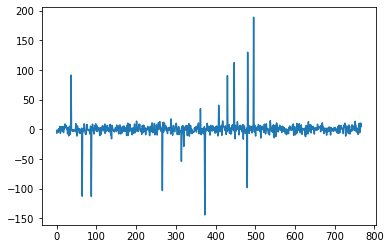

In [49]:
import matplotlib.pyplot as plt
from transformer_utils.partial_forward import partial_forward
output = partial_forward(
    model=model.transformer,  # your `transformers` model
    output_names=[
        'h.11'
    ],
    input_ids=tokens  # the input to run
)

# each of these is a tensor
plt.plot(output['h.11'][0,16].cpu().detach())


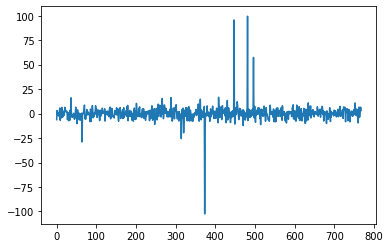

In [52]:
plt.plot(result.hidden_states[11][0,16].cpu().detach())

In [58]:
tout = model.lm_head.forward(model.transformer.ln_f.forward(result.hidden_states[11][0,16]))

#tlogit = model.lm_head.forward(tout)
tokenid = torch.argmax(tout)
tokenizer.decode(tokenid), tokenid, result.logits[0,16,tokenid]

(' flooding',
 tensor(17448, device='cuda:0'),
 tensor(-114.1670, device='cuda:0', grad_fn=<SelectBackward>))

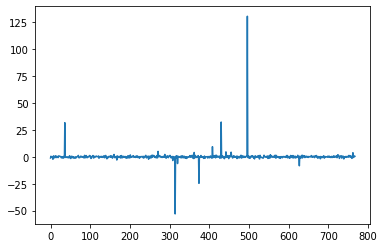

In [57]:
plt.plot(model.transformer.ln_f.forward(result.hidden_states[11][0,16]).cpu().detach())